# COVID-19 Philippines - Prediction Model

Analysis and forecasting for infection rates

In [23]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
import glob
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("setup complete")
print(f"working directory: {os.getcwd()}")

setup complete
working directory: c:\Users\shani\OneDrive\Desktop\pandemic-outbreak-tracker\notebooks


In [24]:
# check available files
data_dir = '../data'
print("Available data files:")
print("\nMain files:")
for f in glob.glob(f'{data_dir}/*.csv'):
    size_mb = os.path.getsize(f) / (1024*1024)
    print(f"  {os.path.basename(f)} ({size_mb:.2f} MB)")

print("\nDaily reports:")
daily_reports = glob.glob(f'{data_dir}/DOH Data Collect - Daily Reports/*.csv')
print(f"  Total files: {len(daily_reports)}")
if daily_reports:
    print(f"  Range: {os.path.basename(daily_reports[0])} to {os.path.basename(daily_reports[-1])}")

Available data files:

Main files:
  Case_Information.csv (1.48 MB)
  Case_Information_20200515.csv (1.32 MB)
  cleaned_ph_covid.csv (0.05 MB)
  features_ph_covid.csv (0.20 MB)
  Testing_Aggregates_20200513.csv (0.08 MB)
  Testing_Lab_Locations.csv (0.00 MB)

Daily reports:
  Total files: 30
  Range: DOH COVID Data Drop_ 20200414 - DOH Data Collect - Daily Report.csv to DOH COVID Data Drop_20200416 - 05 DOH Data Collect - Daily Report.csv


In [25]:
# load case data
case_info_path = '../data/Case_Information.csv'
df_cases = pd.read_csv(case_info_path)

print("Dataset shape:", df_cases.shape)
print("\nColumns:", df_cases.columns.tolist())

Dataset shape: (12091, 16)

Columns: ['case_id', 'age', 'age_group', 'sex', 'date_announced', 'date_recovered', 'date_of_death', 'status', 'date_announced_as_removed', 'province', 'muni_city', 'health_status', 'home_quarantined', 'date_of_onset_of_symptoms', 'pregnant', 'region']


In [26]:
df_cases.head()

,case_id,age,age_group,sex,date_announced,date_recovered,date_of_death,status,date_announced_as_removed,province,muni_city,health_status,home_quarantined,date_of_onset_of_symptoms,pregnant,region
0,C404174,38.0,35 to 39,Female,2020-01-30,NaN,NaN,Recovered,2020-02-07,Negros Oriental,Dumaguete City,Recovered,NaN,2020-01-21,NaN,Central Visayas (Region VII)
1,C462688,44.0,40 to 44,Male,2020-02-03,NaN,2020-02-01,Died,2020-02-02,Negros Oriental,Dumaguete City,Died,NaN,2020-01-18,NaN,Central Visayas (Region VII)
2,C387710,60.0,60 to 64,Female,2020-02-05,2020-01-31,NaN,Recovered,2020-02-05,Bohol,Panglao,Recovered,No,2020-01-21,NaN,Central Visayas (Region VII)
3,C377460,48.0,45 to 49,Male,2020-03-06,NaN,NaN,Recovered,2020-03-27,Metropolitan Manila,Taguig,Recovered,No,2020-03-03,NaN,Metropolitan Manila
4,C498051,62.0,60 to 64,Male,2020-03-06,NaN,2020-03-11,Died,2020-03-12,Rizal,Cainta,Died,No,2020-02-25,NaN,CALABARZON (Region IV-A)


In [27]:
# check missing values
missing_df = pd.DataFrame({
    'Column': df_cases.columns,
    'Type': df_cases.dtypes,
    'Missing': df_cases.isna().sum(),
    'Missing %': (df_cases.isna().sum() / len(df_cases) * 100).round(2)
})
missing_df = missing_df.sort_values('Missing %', ascending=False)
print(missing_df.to_string(index=False))

                   Column    Type  Missing  Missing %
            date_of_death  object    11434      94.57
           date_recovered  object    10854      89.77
                 pregnant  object    10166      84.08
date_announced_as_removed  object     8825      72.99
         home_quarantined  object     6781      56.08
date_of_onset_of_symptoms  object     5530      45.74
                muni_city  object     1038       8.58
                 province  object     1038       8.58
                   region  object     1038       8.58
                      age float64       21       0.17
                age_group  object       21       0.17
                      sex  object        0       0.00
                   status  object        0       0.00
           date_announced  object        0       0.00
                  case_id  object        0       0.00
            health_status  object        0       0.00


In [28]:
# location distribution
if 'ProvRes' in df_cases.columns:
    top_provinces = df_cases['ProvRes'].value_counts().head(20)
    print("Top 20 provinces:")
    print(top_provinces)

In [29]:
# check date columns
date_cols = [col for col in df_cases.columns if any(x in col.lower() for x in ['date', 'confirm', 'admit', 'onset'])]
print(f"Date columns: {date_cols}")

# parse dates
for col in date_cols[:3]:
    try:
        df_cases[col] = pd.to_datetime(df_cases[col], errors='coerce')
        valid_dates = df_cases[col].notna().sum()
        if valid_dates > 0:
            date_range = f"{df_cases[col].min()} to {df_cases[col].max()}"
            print(f"\n{col}:")
            print(f"  Valid: {valid_dates:,} ({valid_dates/len(df_cases)*100:.1f}%)")
            print(f"  Range: {date_range}")
    except Exception as e:
        print(f"{col}: error - {str(e)}")

Date columns: ['date_announced', 'date_recovered', 'date_of_death', 'date_announced_as_removed', 'date_of_onset_of_symptoms']

date_announced:
  Valid: 12,091 (100.0%)
  Range: 2020-01-30 00:00:00 to 2020-05-15 00:00:00

date_recovered:
  Valid: 1,237 (10.2%)
  Range: 2020-01-31 00:00:00 to 2020-05-14 00:00:00

date_of_death:
  Valid: 657 (5.4%)
  Range: 2020-02-01 00:00:00 to 2020-05-15 00:00:00


## Daily aggregation

need to convert individual cases to daily time series by location

In [30]:
def aggregate_daily_cases(df):
    # use confirmation date 
    date_col = 'date_announced' if 'date_announced' in df.columns else 'DateRepConf'
    location_col = 'province' if 'province' in df.columns else 'region'
    
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # remove missing
    df_clean = df.dropna(subset=[date_col, location_col]).copy()
    
    print(f"Using: {date_col}, {location_col}")
    print(f"Valid records: {len(df_clean):,} ({len(df_clean)/len(df)*100:.1f}%)")
    
    # aggregate
    daily_agg = df_clean.groupby([location_col, date_col]).size().reset_index(name='new_cases')
    daily_agg.columns = ['location', 'date', 'new_cases']
    
    return daily_agg.sort_values(['location', 'date']).reset_index(drop=True)

df_daily = aggregate_daily_cases(df_cases)

print(f"\nShape: {df_daily.shape}")
print(f"Date range: {df_daily['date'].min()} to {df_daily['date'].max()}")
print(f"Locations: {df_daily['location'].nunique()}")
print(f"\nSample:")
print(df_daily.head(10))

Using: date_announced, province
Valid records: 11,053 (91.4%)

Shape: (819, 3)
Date range: 2020-01-30 00:00:00 to 2020-05-15 00:00:00
Locations: 61

Sample:
           location       date  new_cases
0              Abra 2020-03-14          1
1              Abra 2020-04-02          1
2              Abra 2020-04-06          1
3  Agusan del Norte 2020-04-08          1
4  Agusan del Norte 2020-04-19          1
5  Agusan del Norte 2020-04-23          1
6             Aklan 2020-03-28          3
7             Aklan 2020-04-03          2
8             Aklan 2020-04-10          1
9             Aklan 2020-05-06          1


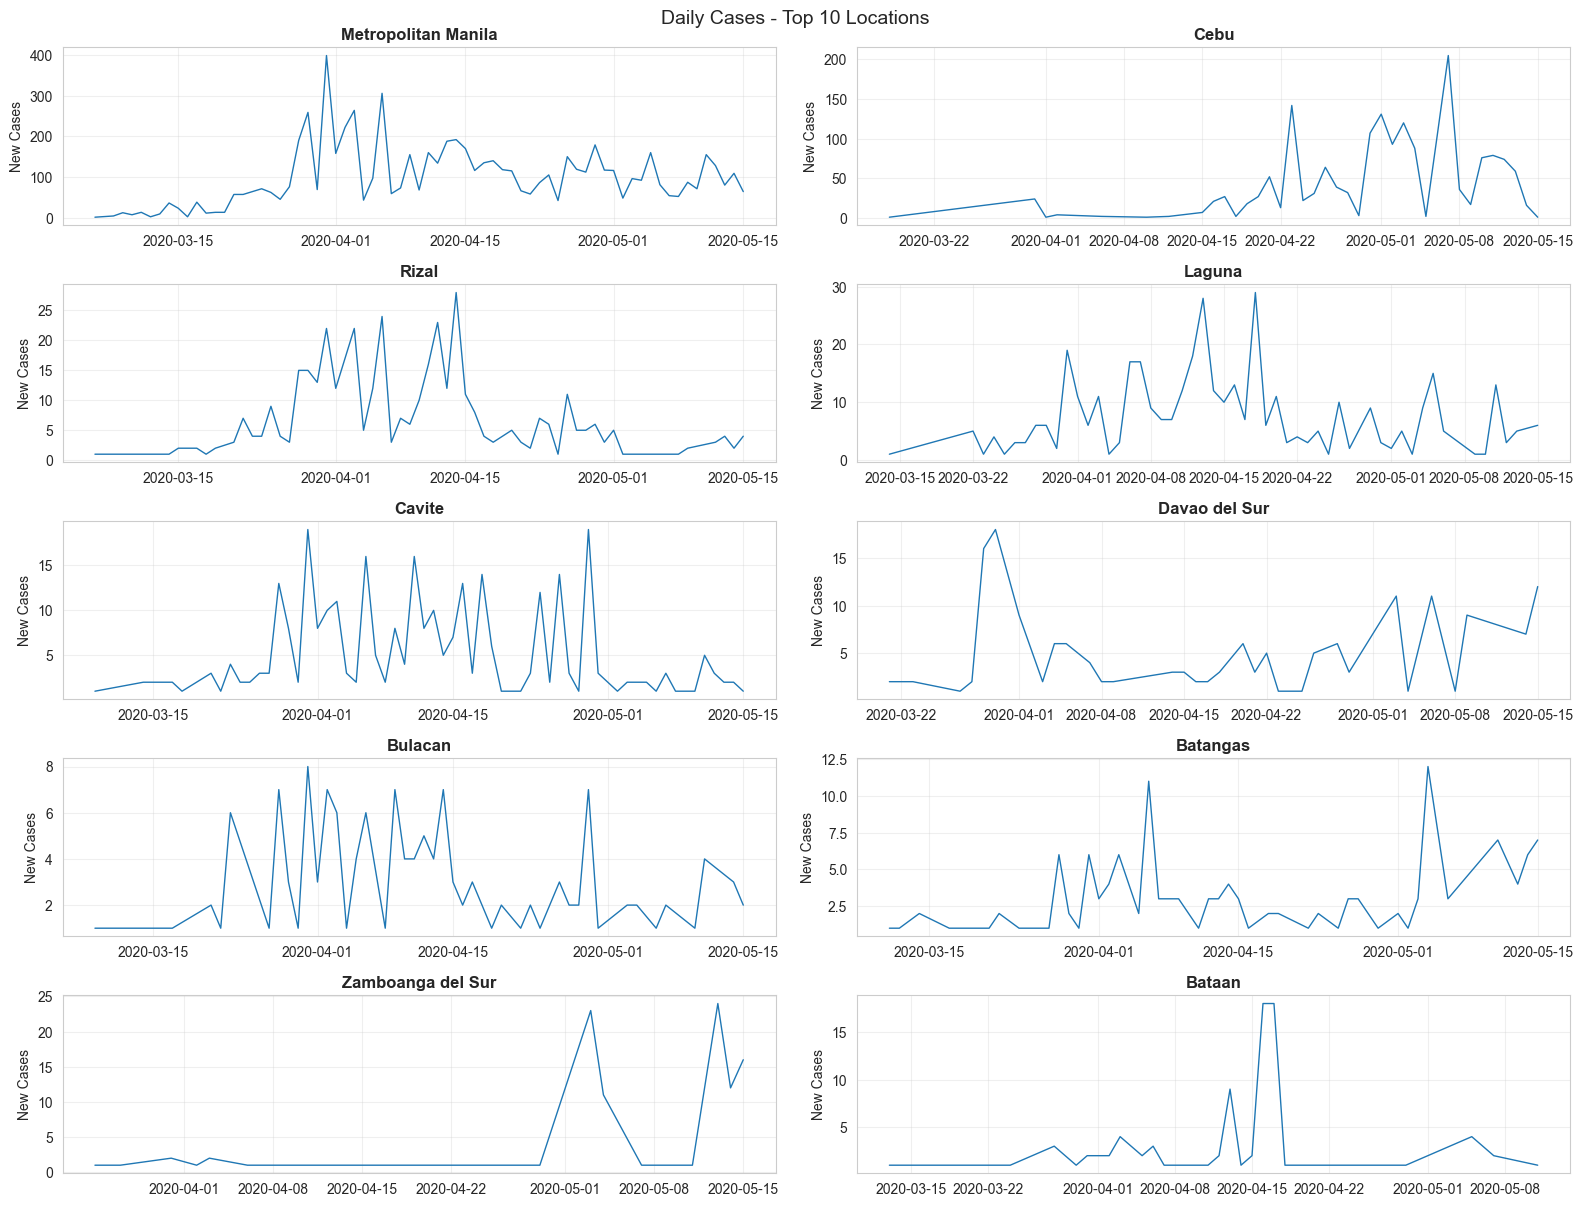


Top 10 by total:
location
Metropolitan Manila    6873
Cebu                   1742
Rizal                   417
Laguna                  392
Cavite                  308
Davao del Sur           173
Bulacan                 141
Batangas                137
Zamboanga del Sur       101
Bataan                   84
Name: new_cases, dtype: int64


In [31]:
# plot top locations
top_locations = df_daily.groupby('location')['new_cases'].sum().nlargest(10).index

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, loc in enumerate(top_locations):
    loc_data = df_daily[df_daily['location'] == loc].set_index('date')
    axes[idx].plot(loc_data.index, loc_data['new_cases'], linewidth=1)
    axes[idx].set_title(f'{loc}', fontweight='bold')
    axes[idx].set_ylabel('New Cases')
    axes[idx].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.suptitle('Daily Cases - Top 10 Locations', fontsize=14, y=1.002)
plt.show()

print("\nTop 10 by total:")
print(df_daily.groupby('location')['new_cases'].sum().nlargest(10))

## Data cleaning

fill missing dates to make continuous time series

In [32]:
def clean_and_fill_time_series(df, date_col='date', loc_col='location', target_col='new_cases'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    all_locations = []
    
    for loc, group in df.groupby(loc_col):
        # create full date range
        date_range = pd.date_range(start=group[date_col].min(), 
                                   end=group[date_col].max(), 
                                   freq='D')
        
        group_indexed = group.set_index(date_col)
        group_filled = group_indexed.reindex(date_range, fill_value=0)
        
        group_filled = group_filled.reset_index()
        group_filled.columns = ['date', 'location', 'new_cases']
        group_filled['location'] = loc
        
        all_locations.append(group_filled)
    
    result = pd.concat(all_locations, ignore_index=True)
    result = result[[loc_col, date_col, target_col]]
    
    return result.sort_values([loc_col, date_col]).reset_index(drop=True)

df_clean = clean_and_fill_time_series(df_daily)

print("Cleaned data shape:", df_clean.shape)
print("\nSample:")
print(df_clean.head(15))

# save
output_path = '../data/cleaned_ph_covid.csv'
df_clean.to_csv(output_path, index=False)
print(f"\nSaved to {output_path}")

Cleaned data shape: (2126, 3)

Sample:
   location       date  new_cases
0      Abra 2020-03-14          1
1      Abra 2020-03-15          0
2      Abra 2020-03-16          0
3      Abra 2020-03-17          0
4      Abra 2020-03-18          0
5      Abra 2020-03-19          0
6      Abra 2020-03-20          0
7      Abra 2020-03-21          0
8      Abra 2020-03-22          0
9      Abra 2020-03-23          0
10     Abra 2020-03-24          0
11     Abra 2020-03-25          0
12     Abra 2020-03-26          0
13     Abra 2020-03-27          0
14     Abra 2020-03-28          0

Saved to ../data/cleaned_ph_covid.csv


## Feature engineering

creating lag features + rolling stats for modeling

In [33]:
def create_forecast_features(df_loc, target='new_cases', n_lags=14):
    df = df_loc.sort_values('date').copy()
    
    # lag features
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    
    # rolling stats
    df['roll_mean_7'] = df[target].shift(1).rolling(window=7, min_periods=1).mean()
    df['roll_mean_14'] = df[target].shift(1).rolling(window=14, min_periods=1).mean()
    df['roll_std_7'] = df[target].shift(1).rolling(window=7, min_periods=1).std()
    df['roll_max_7'] = df[target].shift(1).rolling(window=7, min_periods=1).max()
    df['roll_min_7'] = df[target].shift(1).rolling(window=7, min_periods=1).min()
    
    # temporal features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    df['roll_std_7'] = df['roll_std_7'].fillna(0)
    
    return df

# apply to all locations
print("Creating features...")
all_features = []

for loc in df_clean['location'].unique():
    loc_data = df_clean[df_clean['location'] == loc].copy()
    loc_features = create_forecast_features(loc_data)
    all_features.append(loc_features)

df_features = pd.concat(all_features, ignore_index=True)
df_features = df_features.dropna(subset=['lag_1', 'lag_7', 'lag_14'])

print(f"Features shape: {df_features.shape}")
print(f"\nFeature columns:")
feature_cols = [col for col in df_features.columns if col not in ['location', 'date', 'new_cases']]
print(feature_cols)

features_path = '../data/features_ph_covid.csv'
df_features.to_csv(features_path, index=False)
print(f"\nSaved to {features_path}")

df_features.head(10)

Creating features...
Features shape: (1443, 27)

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'roll_mean_7', 'roll_mean_14', 'roll_std_7', 'roll_max_7', 'roll_min_7', 'day_of_week', 'day_of_month', 'month', 'week_of_year', 'days_since_start']

Saved to ../data/features_ph_covid.csv
Features shape: (1443, 27)

Feature columns:
['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'roll_mean_7', 'roll_mean_14', 'roll_std_7', 'roll_max_7', 'roll_min_7', 'day_of_week', 'day_of_month', 'month', 'week_of_year', 'days_since_start']

Saved to ../data/features_ph_covid.csv


,location,date,new_cases,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,roll_mean_7,roll_mean_14,roll_std_7,roll_max_7,roll_min_7,day_of_week,day_of_month,month,week_of_year,days_since_start
14,Abra,2020-03-28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.071429,0.000000,0.0,0.0,5,28,3,13,14
15,Abra,2020-03-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,6,29,3,13,15
16,Abra,2020-03-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,30,3,14,16
17,Abra,2020-03-31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1,31,3,14,17
18,Abra,2020-04-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2,1,4,14,18
19,Abra,2020-04-02,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,3,2,4,14,19
20,Abra,2020-04-03,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.071429,0.377964,1.0,0.0,4,3,4,14,20
21,Abra,2020-04-04,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.071429,0.377964,1.0,0.0,5,4,4,14,21
22,Abra,2020-04-05,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.071429,0.377964,1.0,0.0,6,5,4,14,22
23,Abra,2020-04-06,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.071429,0.377964,1.0,0.0,0,6,4,15,23


## Model training

using lightgbm for regression

In [34]:
import subprocess
import sys

try:
    import lightgbm as lgb
    print("lightgbm already installed")
except ImportError:
    print("installing lightgbm...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb
    print("done")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

print(f"version: {lgb.__version__}")

lightgbm already installed
version: 4.6.0


In [35]:
# select top locations
top_n_locations = 10
top_locations_to_model = df_features.groupby('location')['new_cases'].sum().nlargest(top_n_locations).index.tolist()

print(f"Training for top {top_n_locations}:")
for i, loc in enumerate(top_locations_to_model, 1):
    total = df_features[df_features['location'] == loc]['new_cases'].sum()
    print(f"  {i}. {loc}: {total:,} cases")

Training for top 10:
  1. Metropolitan Manila: 6,702 cases
  2. Cebu: 1,717 cases
  3. Rizal: 405 cases
  4. Laguna: 374 cases
  5. Cavite: 296 cases
  6. Bulacan: 134 cases
  7. Batangas: 128 cases
  8. Davao del Sur: 121 cases
  9. Zamboanga del Sur: 92 cases
  10. Bataan: 81 cases
  5. Cavite: 296 cases
  6. Bulacan: 134 cases
  7. Batangas: 128 cases
  8. Davao del Sur: 121 cases
  9. Zamboanga del Sur: 92 cases
  10. Bataan: 81 cases


In [36]:
def train_location_model(df_loc, location_name, test_days=14, validation_days=14):
    # get features
    feature_cols = [col for col in df_loc.columns 
                   if col.startswith(('lag_', 'roll_', 'day_', 'month', 'week_', 'days_'))]
    target_col = 'new_cases'
    
    df_loc = df_loc.sort_values('date').reset_index(drop=True)
    
    # split data
    total_rows = len(df_loc)
    test_start = total_rows - test_days
    val_start = test_start - validation_days
    
    train = df_loc.iloc[:val_start].copy()
    validation = df_loc.iloc[val_start:test_start].copy()
    test = df_loc.iloc[test_start:].copy()
    
    print(f"\n{location_name}")
    print(f"  train: {len(train)} samples")
    print(f"  val: {len(validation)} samples")
    print(f"  test: {len(test)} samples")
    
    X_train, y_train = train[feature_cols], train[target_col]
    X_val, y_val = validation[feature_cols], validation[target_col]
    X_test, y_test = test[feature_cols], test[target_col]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42
    }
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    
    print(f"  results:")
    print(f"    train - MAE: {metrics['train_mae']:.2f} RMSE: {metrics['train_rmse']:.2f}")
    print(f"    val   - MAE: {metrics['val_mae']:.2f} RMSE: {metrics['val_rmse']:.2f}")
    print(f"    test  - MAE: {metrics['test_mae']:.2f} RMSE: {metrics['test_rmse']:.2f} R2: {metrics['test_r2']:.3f}")
    
    return model, metrics, (train, validation, test), feature_cols

# train all
models = {}
all_metrics = []

for location in top_locations_to_model:
    loc_data = df_features[df_features['location'] == location].copy()
    
    if len(loc_data) < 50:
        print(f"\nskipping {location} - not enough data")
        continue
    
    try:
        model, metrics, splits, features = train_location_model(loc_data, location)
        
        # save
        model_path = f'../models/lgb_{location.replace(" ", "_").replace("/", "_")}.pkl'
        os.makedirs('../models', exist_ok=True)
        joblib.dump(model, model_path)
        
        models[location] = {
            'model': model,
            'metrics': metrics,
            'features': features,
            'data': loc_data
        }
        
        all_metrics.append({'location': location, **metrics})
        
    except Exception as e:
        print(f"\nerror with {location}: {str(e)}")

print(f"\ntrained {len(models)} models")


Metropolitan Manila
  train: 29 samples
  val: 14 samples
  test: 14 samples
  results:
    train - MAE: 72.33 RMSE: 89.48
    val   - MAE: 35.10 RMSE: 43.64
    test  - MAE: 49.89 RMSE: 55.40 R2: -1.576

skipping Cebu - not enough data

Rizal
  train: 29 samples
  val: 14 samples
  test: 14 samples
  results:
skipping Cebu - not enough data

Rizal
  train: 29 samples
  val: 14 samples
  test: 14 samples
  results:
    train - MAE: 6.07 RMSE: 7.33
    val   - MAE: 6.29 RMSE: 6.72
    test  - MAE: 9.57 RMSE: 9.67 R2: -50.438

skipping Laguna - not enough data

Cavite
  train: 26 samples
  val: 14 samples
  test: 14 samples
  results:
    train - MAE: 4.13 RMSE: 4.92
    val   - MAE: 5.65 RMSE: 6.07
    test  - MAE: 5.26 RMSE: 5.38 R2: -22.914

Bulacan
  train: 26 samples
  val: 14 samples
  test: 14 samples

    train - MAE: 6.07 RMSE: 7.33
    val   - MAE: 6.29 RMSE: 6.72
    test  - MAE: 9.57 RMSE: 9.67 R2: -50.438

skipping Laguna - not enough data

Cavite
  train: 26 samples
  val:

In [37]:
# metrics summary
metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.sort_values('test_mae')

print("Model performance:")
print(metrics_df.to_string(index=False))

# save
metrics_path = '../reports'
os.makedirs(metrics_path, exist_ok=True)
metrics_df.to_csv(f'{metrics_path}/model_metrics.csv', index=False)
print(f"\nsaved to {metrics_path}/model_metrics.csv")

Model performance:
           location  train_mae  train_rmse   val_mae  val_rmse  test_mae  test_rmse    test_r2
            Bulacan   2.192308    2.544573  2.351648  2.527407  2.423077   2.679364  -3.495472
           Batangas   1.763889    2.477678  1.666667  1.946711  2.928571   3.602799  -0.004387
             Cavite   4.130178    4.922626  5.653846  6.074958  5.263736   5.377370 -22.913739
              Rizal   6.068966    7.334378  6.285714  6.718843  9.571429   9.665846 -50.438202
Metropolitan Manila  72.332937   89.483802 35.100985 43.637123 49.894089  55.403860  -1.576337

saved to ../reports/model_metrics.csv


## 7-day forecasts

generating predictions for next week

In [38]:
def generate_7day_forecast(location, model_data, horizon=7):
    model = model_data['model']
    feature_cols = model_data['features']
    df_loc = model_data['data'].sort_values('date').copy()
    
    last_row = df_loc.iloc[-1].copy()
    last_date = last_row['date']
    
    predictions = []
    current_row = last_row.copy()
    
    for day in range(1, horizon + 1):
        X = current_row[feature_cols].values.reshape(1, -1)
        pred = max(0, model.predict(X)[0])
        pred_date = last_date + timedelta(days=day)
        
        predictions.append({
            'date': pred_date.strftime('%Y-%m-%d'),
            'predicted_cases': round(pred, 2),
            'day_ahead': day
        })
        
        # update features for next iteration
        for lag in range(14, 1, -1):
            if f'lag_{lag}' in current_row.index:
                current_row[f'lag_{lag}'] = current_row.get(f'lag_{lag-1}', 0)
        current_row['lag_1'] = pred
        
        current_row['roll_mean_7'] = (current_row['roll_mean_7'] * 6 + pred) / 7
        current_row['roll_mean_14'] = (current_row['roll_mean_14'] * 13 + pred) / 14
        
        current_row['day_of_week'] = pred_date.dayofweek
        current_row['day_of_month'] = pred_date.day
        current_row['month'] = pred_date.month
        current_row['week_of_year'] = pred_date.isocalendar()[1]
        current_row['days_since_start'] += 1
    
    return predictions

# generate for all
all_predictions = {}
prediction_summary = []

print("Generating forecasts...")

for location, model_data in models.items():
    predictions = generate_7day_forecast(location, model_data)
    all_predictions[location] = predictions
    
    total_pred = sum(p['predicted_cases'] for p in predictions)
    last_7_actual = model_data['data'].tail(7)['new_cases'].sum()
    
    prediction_summary.append({
        'location': location,
        'last_7_days_actual': last_7_actual,
        'next_7_days_predicted': round(total_pred, 2),
        'change_pct': round((total_pred - last_7_actual) / last_7_actual * 100, 1) if last_7_actual > 0 else 0
    })
    
    print(f"\n{location}")
    print(f"  last 7 days: {last_7_actual:.0f}")
    print(f"  next 7 days: {total_pred:.0f}")

summary_df = pd.DataFrame(prediction_summary)
print("\nSummary:")
print(summary_df.to_string(index=False))

Generating forecasts...

Metropolitan Manila
  last 7 days: 694
  next 7 days: 942

Rizal
Rizal
  last 7 days: 15
  next 7 days: 77

  last 7 days: 15
  next 7 days: 77

Cavite
  last 7 days: 15
  next 7 days: 50

Cavite
  last 7 days: 15
  next 7 days: 50

Bulacan
  last 7 days: 10
  next 7 days: 25

Batangas
  last 7 days: 24
  next 7 days: 20

Summary:
           location  last_7_days_actual  next_7_days_predicted  change_pct
Metropolitan Manila                 694                 941.85        35.7
              Rizal                  15                  77.00       413.3
             Cavite                  15                  50.33       235.5
            Bulacan                  10                  25.06       150.6
           Batangas                  24                  19.81       -17.5

Bulacan
  last 7 days: 10
  next 7 days: 25

Batangas
  last 7 days: 24
  next 7 days: 20

Summary:
           location  last_7_days_actual  next_7_days_predicted  change_pct
Metropolitan Man

In [39]:
# export to JSON for web dev
predictions_json_path = '../predictions_7d.json'
with open(predictions_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=2)

print(f"saved to {predictions_json_path}")
print(f"{len(all_predictions)} locations, 7 days each")

# also CSV
predictions_flat = []
for location, preds in all_predictions.items():
    for p in preds:
        predictions_flat.append({
            'location': location,
            **p
        })

predictions_df = pd.DataFrame(predictions_flat)
predictions_csv_path = '../predictions_7d.csv'
predictions_df.to_csv(predictions_csv_path, index=False)
print(f"CSV: {predictions_csv_path}")

predictions_df.head(15)

saved to ../predictions_7d.json
5 locations, 7 days each
CSV: ../predictions_7d.csv


,location,date,predicted_cases,day_ahead
0,Metropolitan Manila,2020-05-16,134.55,1
1,Metropolitan Manila,2020-05-17,134.55,2
2,Metropolitan Manila,2020-05-18,134.55,3
3,Metropolitan Manila,2020-05-19,134.55,4
4,Metropolitan Manila,2020-05-20,134.55,5
5,Metropolitan Manila,2020-05-21,134.55,6
6,Metropolitan Manila,2020-05-22,134.55,7
7,Rizal,2020-05-16,11.00,1
8,Rizal,2020-05-17,11.00,2
9,Rizal,2020-05-18,11.00,3


## visualizations

plotting predictions vs history

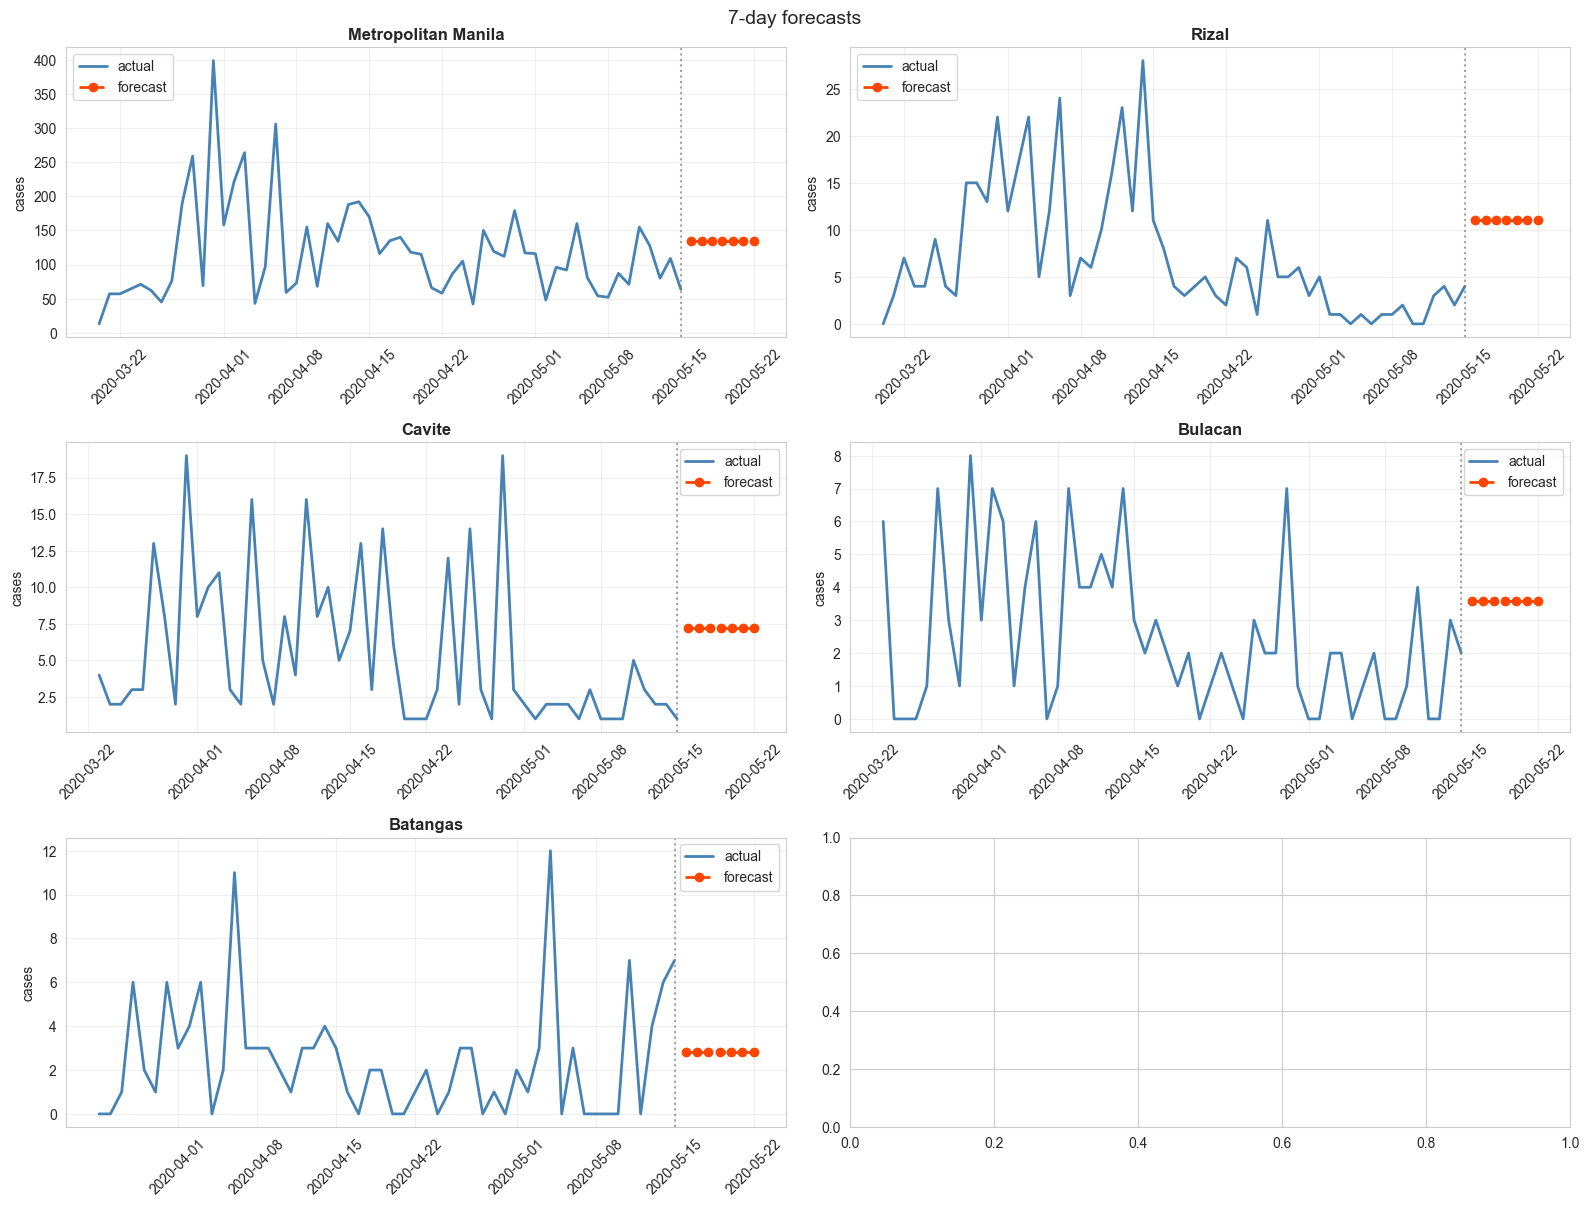

saved to ../reports/predictions_visualization.png


In [40]:
# plot predictions vs history
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, location in enumerate(list(all_predictions.keys())[:6]):
    # last 60 days
    hist_data = models[location]['data'].tail(60).copy()
    
    preds = all_predictions[location]
    pred_dates = pd.to_datetime([p['date'] for p in preds])
    pred_values = [p['predicted_cases'] for p in preds]
    
    axes[idx].plot(hist_data['date'], hist_data['new_cases'], 
                   label='actual', linewidth=2, color='steelblue')
    axes[idx].plot(pred_dates, pred_values, 
                   label='forecast', linewidth=2, 
                   linestyle='--', marker='o', color='orangered')
    axes[idx].axvline(x=hist_data['date'].iloc[-1], 
                      color='gray', linestyle=':', alpha=0.7)
    axes[idx].set_title(location, fontweight='bold')
    axes[idx].set_ylabel('cases')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('7-day forecasts', fontsize=14, y=1.002)
plt.savefig('../reports/predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("saved to ../reports/predictions_visualization.png")

## backtesting

quick validation using rolling windows

In [41]:
def rolling_backtest(df_loc, feature_cols, n_splits=5, forecast_horizon=7):
    results = []
    total_days = len(df_loc)
    test_size = forecast_horizon
    step = 14
    
    for i in range(n_splits):
        test_end = total_days - (n_splits - i - 1) * step
        test_start = test_end - test_size
        train_end = test_start
        
        if train_end < 30:
            continue
        
        train = df_loc.iloc[:train_end]
        test = df_loc.iloc[test_start:test_end]
        
        if len(test) < forecast_horizon:
            continue
        
        X_train = train[feature_cols]
        y_train = train['new_cases']
        X_test = test[feature_cols]
        y_test = test['new_cases']
        
        train_data = lgb.Dataset(X_train, label=y_train)
        params = {'objective': 'regression', 'metric': 'mae', 'verbose': -1, 'seed': 42}
        model = lgb.train(params, train_data, num_boost_round=100)
        
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'fold': i + 1,
            'train_size': len(train),
            'test_start': test['date'].iloc[0].strftime('%Y-%m-%d'),
            'test_end': test['date'].iloc[-1].strftime('%Y-%m-%d'),
            'mae': mae,
            'rmse': rmse
        })
    
    return pd.DataFrame(results)

# test top 3
print("Backtesting...")
backtest_results = []

for location in list(models.keys())[:3]:
    print(f"\n{location}")
    loc_data = models[location]['data'].copy()
    feature_cols = models[location]['features']
    
    try:
        results = rolling_backtest(loc_data, feature_cols, n_splits=4)
        results['location'] = location
        backtest_results.append(results)
        
        print(results[['fold', 'test_start', 'test_end', 'mae', 'rmse']].to_string(index=False))
        print(f"avg MAE: {results['mae'].mean():.2f}, avg RMSE: {results['rmse'].mean():.2f}")
        
    except Exception as e:
        print(f"error: {str(e)}")

if backtest_results:
    backtest_df = pd.concat(backtest_results, ignore_index=True)
    backtest_path = '../reports/backtest_results.csv'
    backtest_df.to_csv(backtest_path, index=False)
    print(f"\nsaved to {backtest_path}")

Backtesting...

Metropolitan Manila
 fold test_start   test_end       mae      rmse
    3 2020-04-25 2020-05-01 29.357143 39.684020
    4 2020-05-09 2020-05-15 43.978120 46.729258
avg MAE: 36.67, avg RMSE: 43.21

Rizal
 fold test_start   test_end      mae     rmse
    3 2020-04-25 2020-05-01 4.924603 5.370232
    4 2020-05-09 2020-05-15 1.781698 1.937224
avg MAE: 3.35, avg RMSE: 3.65

Cavite
 fold test_start   test_end      mae     rmse
    3 2020-04-25 2020-05-01 6.064935 6.648450
    4 2020-05-09 2020-05-15 2.465241 2.803155
avg MAE: 4.27, avg RMSE: 4.73

saved to ../reports/backtest_results.csv


In [42]:
print("="*60)
print("DONE")
print("="*60)
print(f"\nmodels trained: {len(models)}")
print(f"predictions: {len(all_predictions)} locations x 7 days")
print(f"date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"\nfiles created:")
print("  predictions_7d.json")
print("  predictions_7d.csv")
print("  reports/model_metrics.csv")
print("  reports/predictions_visualization.png")
print(f"  models/ ({len(models)} .pkl files)")

DONE

models trained: 5
predictions: 5 locations x 7 days
date range: 2020-01-30 00:00:00 to 2020-05-15 00:00:00

files created:
  predictions_7d.json
  predictions_7d.csv
  reports/model_metrics.csv
  reports/predictions_visualization.png
  models/ (5 .pkl files)
